# CSE527 Homework2
**Due date: 23:59 on Oct 11, 2018 (Thursday)**

## Description
---
In this homework you will experiment with SIFT features for scene matching and object recognition. You will work with the SIFT tutorial and code from the University of Toronto. In the compressed homework file (hw2_files.zip), you will find the tutorial document (tutSIFT04.pdf) and a paper from the International Journal of Computer Vision (ijcv04.pdf) describing SIFT and object recognition. Although the tutorial document assumes matlab implemention, you should still be able to follow the technical details in it. In addition, you are **STRONGLY** encouraged to read this paper unless you’re already quite familiar with matching and recognition using SIFT.

There are 3 problems in this homework with a total of 100 points. Two bonus questions with extra 5 and 15 points are provided under problem 1 and 2 respectively. The maximum points you may earn from this homework is 100 + 20 = 120 points. Be sure to read **Submission Guidelines** below. They are important.

## Using SIFT in OpenCV 3.x.x
---
Feature descriptors like SIFT and SURF are no longer included in OpenCV since version 3. This section provides instructions on how to use SIFT for those who use OpenCV 3.x.x. If you are using OpenCV 2.x.x then you are all set, please skip this section. Read this if you are curious about why SIFT is removed https://www.pyimagesearch.com/2015/07/16/where-did-sift-and-surf-go-in-opencv-3/.

One simple way to use the OpenCV in-built function `SIFT` is to switch back to version 2.x.x, but if you want to keep using OpenCV 3.x.x, do the following:
1. uninstall your original OpenCV package
2. install opencv-contrib-python using pip (pip is a Python tool for installing packages written in Python), please find detailed instructions at https://pypi.python.org/pypi/opencv-contrib-python

After you have your OpenCV set up, you should be able to use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object, whose functions are listed at http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html

## Some Resources
---
In addition to the tutorial document, the following resources can definitely help you in this homework:
- http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html
- http://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html
- http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html?highlight=sift#cv2.SIFT
- http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html

In [1]:
# import packages here
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

## Problem 1: Match transformed images using SIFT features
{40 points + bonus 5} You will transform a given image, and match it back to the original image using SIFT keypoints.

- **Step 1 (5pt)**. Use the function from SIFT class to detect keypoints from the given image. Plot the image with keypoints scale and orientation overlaid.

- **Step 2 (10pt)**. Rotate your image counter clockwise by 80 degrees with the `cv2.warpAffine` function. Extract SIFT keypoints for this rotated image and plot the rotated picture with keypoints scale and orientation overlaid just as in step 1.

- **Step 3 (15pt)**. Match the SIFT keypoints of the original image and the rotated imag using the `knnMatch` function in the `cv2.BFMatcher` class. Discard bad matches using the ratio test proposed by D.Lowe in the SIFT paper. Use **0.1** as the ratio in this homework. Note that this is for display purpose only. Draw the filtered good keypoint matches on the image and display it. The image you draw should have two images side by side with matching lines across them.

- **Step 4 (10pt)**. Use the RANSAC algorithm to find the affine transformation from the rotated image to the original image. You are not required to implement the RANSAC algorithm yourself, instead you could use the `cv2.findHomography` function (set the 3rd parameter `method` to `cv2.RANSAC`) to compute the transformation matrix. Transform the rotated image back using this matrix and the `cv2.warpPerspective` function. Display the recovered image.

- **Bonus (5pt)**. You might have noticed that the rotated image from step 2 is cropped. Rotate the image without any cropping and you will be awarded an extra 5 points.

In [2]:
def rotateImageNoCrop(img, angle): 
    '''
    This rotateImage function takes care of rotation without cropping(Bonus for Q1)
    '''
    # find center coordinates of the image
    center = (img.shape[1] // 2, img.shape[0] // 2)
 
    #get the rotation matrix based on the angle 
    rotnMatrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # get the cosine and sine component of the rotation
    radians = math.radians(angle)
    sine_comp = math.sin(radians)
    cosine_comp = math.cos(radians)
 
    # figure out the new rows and new cols for the new rotated image boundary
    newCols = int((img.shape[0] * sine_comp) + (img.shape[1] * cosine_comp))
    newRows = int((img.shape[0] * cosine_comp) + (img.shape[1] * sine_comp))
 
    # modify the matrix to factor translation of the center for the new rotated image boundary
    rotnMatrix[0, 2] += (newCols / 2) - center[0]
    rotnMatrix[1, 2] += (newRows / 2) - center[1]
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(img, rotnMatrix, (newCols, newRows))


def rotateImage(img, angle): 
    '''
    This rotateImage function does not take care of cropping once the image is rotated
    '''
    # find center coordinates of the image
    center = (img.shape[1] // 2, img.shape[0] // 2)
 
    #get the rotation matrix based on the angle 
    rotnMatrix = cv2.getRotationMatrix2D(center, angle, 1.0)
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(img, rotnMatrix, (img.shape[0], img.shape[1]))

Transformation Matrix = 
[[ 1.73580054e-01 -9.84682862e-01  3.23305324e+02]
 [ 9.85032935e-01  1.73926521e-01 -6.48598728e+01]
 [-2.91574995e-07  9.55451779e-07  1.00000000e+00]]


(-0.5, 399.5, 319.5, -0.5)

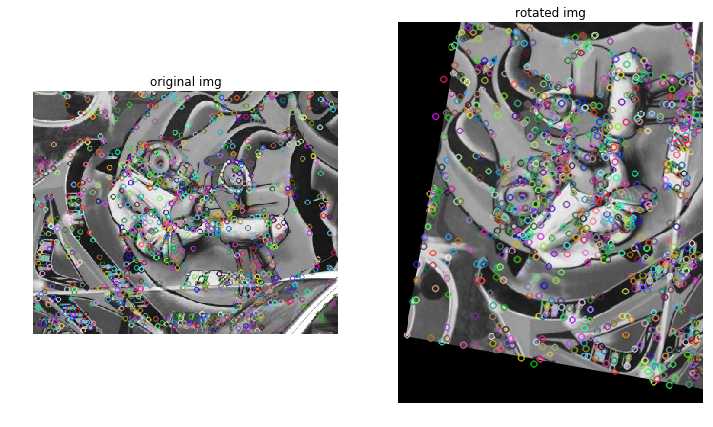

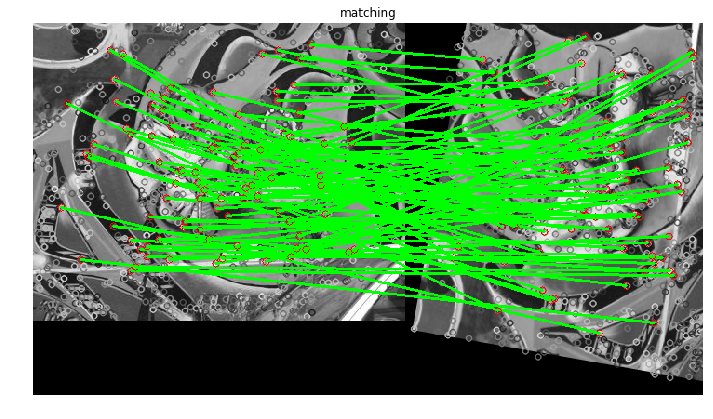

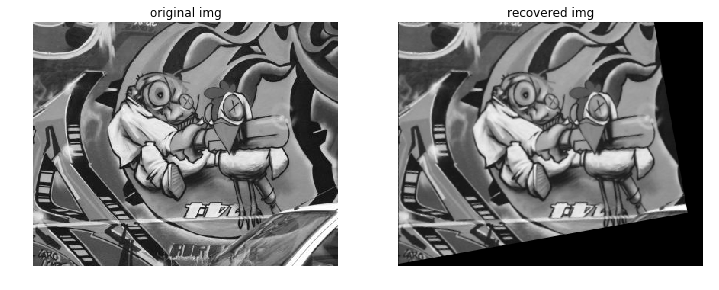

In [3]:
def drawMatches(img1, kp1, img2, kp2, matches):
    """
    My own implementation of cv2.drawMatches as OpenCV 2.4.9
    does not have this function available but it's supported in
    OpenCV 3.0.0

    This function takes in two images with their associated 
    keypoints, as well as a list of DMatch data structure (matches) 
    that contains which keypoints matched in which images.

    An image will be produced where a montage is shown with
    the first image followed by the second image beside it.

    Keypoints are delineated with circles, while lines are connected
    between matching keypoints.

    img1,img2 - Grayscale images
    kp1,kp2 - Detected list of keypoints through any of the OpenCV keypoint 
              detection algorithms
    matches - A list of matches of corresponding keypoints through any
              OpenCV keypoint matching algorithm
    """

    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    # Create the output image
    # The rows of the output are the largest between the two images
    # and the columns are simply the sum of the two together
    # The intent is to make this a colour image, so make this 3 channels
    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')
    #print("out.shape ",out.shape)
    #print("img1.shape ",img1.shape)
    

    # Place the first image to the left
    out[:rows1,:cols1] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0,255,0), 2)

    # Also return the image if you'd like a copy
    return out

# Read image
img_input = cv2.imread('SourceImages/sift_input.jpg', 0)
#print(img_input.shape)

# initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
keypoint1, descriptor1 = sift.detectAndCompute(img_input, None)

# Draw keypoints on the image
# ===== This is your first output =====
res1 = cv2.drawKeypoints(img_input, keypoint1, img_input)
#print(res1.shape)

# rotate image
rotated_img_input= rotateImage(img_input, angle=80) #regular rotation 

# find the keypoints and descriptors on the rotated image
keypoint2, descriptor2 = sift.detectAndCompute(rotated_img_input, None)

# Draw keypoints on the rotated image
# ===== This is your second output =====
res2 = cv2.drawKeypoints(rotated_img_input, keypoint2, rotated_img_input)
#print(res2.shape)

# ====== Plot functions, DO NOT CHANGE =====
# Plot result images
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(res1, 'gray')
plt.title('original img')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(res2, 'gray')
plt.title('rotated img')
plt.axis('off')
# ==========================================

# compute feature matching
good_matches = [] # Matches that are within the good ratio are added to this list
bf = cv2.BFMatcher()
knnMatches = bf.knnMatch(descriptor1,descriptor2, k=2)

# Apply ratio test
for i,(m,n) in enumerate(knnMatches):
    if m.distance < 0.10 * n.distance:
        good_matches.append(m)

# draw matching results with the given drawMatches function
# ===== This is your third output =====
res3 =  drawMatches(cv2.cvtColor(res1, cv2.COLOR_BGR2GRAY),keypoint1,cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY),keypoint2,good_matches) #,None,flags=2,**draw_params)

# ====== Plot functions, DO NOT CHANGE =====
plt.figure(figsize=(12,8))
plt.imshow(res3)
plt.title('matching')
plt.axis('off')
# ==========================================


# estimate similarity transform
if len(good_matches) > 4:
    
    # Extract location of good matches
    src_pts = np.zeros((len(good_matches), 2), dtype=np.float32)
    target_pts = np.zeros((len(good_matches), 2), dtype=np.float32)
 
    #print(matches)
    for i, match in enumerate(good_matches):
        src_pts[i, :] = keypoint1[match.queryIdx].pt
        target_pts[i, :] = keypoint2[match.trainIdx].pt
   
    # find perspective transform matrix using RANSAC
    transformMat, mask = cv2.findHomography(target_pts, src_pts, cv2.RANSAC, ransacReprojThreshold=5.0)
    print "Transformation Matrix = \n", transformMat
 
    height, width = img_input.shape # ref image shape
    
    # mapping rotataed image back with the calculated rotation matrix
    # ===== This is your fourth output =====
    res4 = cv2.warpPerspective(rotated_img_input, transformMat, (width, height))
    
else:
    print "Not enough matches are found - %d/%d" % (len(good_matches),4)

# ====== Plot functions, DO NOT CHANGE =====
# plot result images
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(img_input, 'gray')
plt.title('original img')
plt.axis('off')
    
plt.subplot(1, 2, 2)
plt.imshow(res4, 'gray')
plt.title('recovered img')  
plt.axis('off')
# ==========================================


#################################################################################
################################# Q1 BONUS PART #################################
#################################################################################
Transformation Matrix = 
[[ 1.73565418e-01 -9.84812353e-01  3.87733646e+02]
 [ 9.84895573e-01  1.73675200e-01 -6.80402225e+01]
 [ 9.89784357e-08  3.78585148e-09  1.00000000e+00]]


(-0.5, 399.5, 319.5, -0.5)

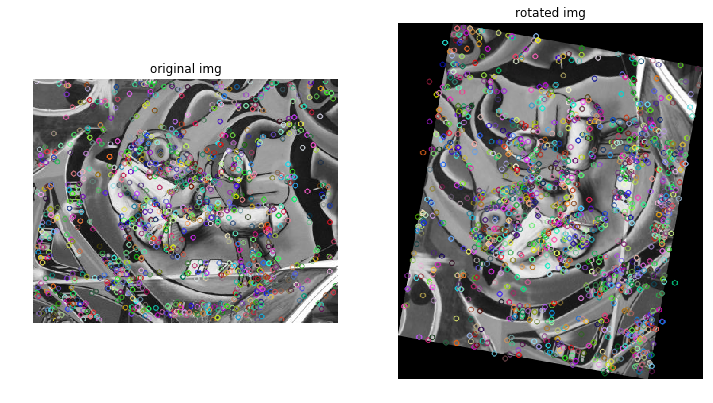

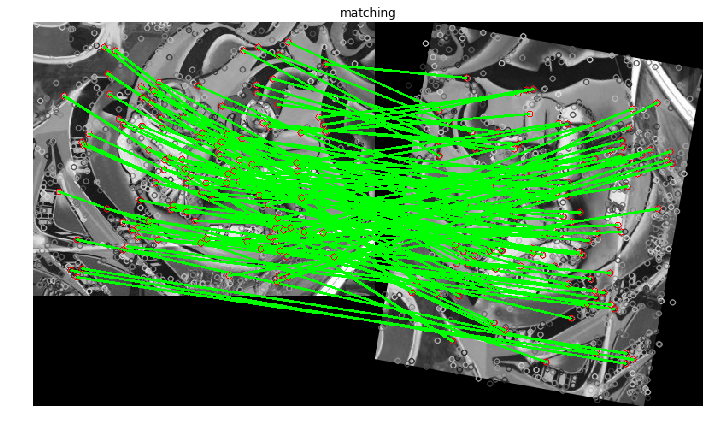

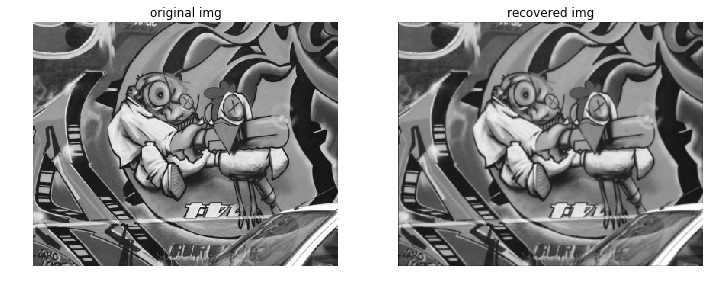

In [4]:
###### Q1 BONUS PART - rotation without cropping  #################################

print('#################################################################################')
print('################################# Q1 BONUS PART #################################')
print('#################################################################################')

# Read image
img_input = cv2.imread('SourceImages/sift_input.jpg', 0)
#print(img_input.shape)

# initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
keypoint1, descriptor1 = sift.detectAndCompute(img_input, None)

# Draw keypoints on the image
# ===== This is your first output =====
res1 = cv2.drawKeypoints(img_input, keypoint1, img_input)
#print(res1.shape)

# rotate image
rotated_img_input= rotateImageNoCrop(img_input, angle=80) #rotation without cropping(Bonus for Q1)

# find the keypoints and descriptors on the rotated image
keypoint2, descriptor2 = sift.detectAndCompute(rotated_img_input, None)

# Draw keypoints on the rotated image
# ===== This is your second output =====
res2 = cv2.drawKeypoints(rotated_img_input, keypoint2, rotated_img_input)
#print(res2.shape)

# ====== Plot functions, DO NOT CHANGE =====
# Plot result images
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(res1, 'gray')
plt.title('original img')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(res2, 'gray')
plt.title('rotated img')
plt.axis('off')
# ==========================================

# compute feature matching
good_matches = [] # Matches that are within the good ratio are added to this list
bf = cv2.BFMatcher()
knnMatches = bf.knnMatch(descriptor1,descriptor2, k=2)

# Apply ratio test
for i,(m,n) in enumerate(knnMatches):
    if m.distance < 0.10 * n.distance:
        good_matches.append(m)

# draw matching results with the given drawMatches function
# ===== This is your third output =====
res3 =  drawMatches(cv2.cvtColor(res1, cv2.COLOR_BGR2GRAY),keypoint1,cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY),keypoint2,good_matches) #,None,flags=2,**draw_params)

# ====== Plot functions, DO NOT CHANGE =====
plt.figure(figsize=(12,8))
plt.imshow(res3)
plt.title('matching')
plt.axis('off')
# ==========================================


# estimate similarity transform
if len(good_matches) > 4:
    
    # Extract location of good matches
    src_pts = np.zeros((len(good_matches), 2), dtype=np.float32)
    target_pts = np.zeros((len(good_matches), 2), dtype=np.float32)
 
    #print(matches)
    for i, match in enumerate(good_matches):
        src_pts[i, :] = keypoint1[match.queryIdx].pt
        target_pts[i, :] = keypoint2[match.trainIdx].pt
   
    # find perspective transform matrix using RANSAC
    transformMat, mask = cv2.findHomography(target_pts, src_pts, cv2.RANSAC, ransacReprojThreshold=5.0)
    print "Transformation Matrix = \n", transformMat
 
    height, width = img_input.shape # ref image shape
    
    # mapping rotataed image back with the calculated rotation matrix
    # ===== This is your fourth output =====
    res4 = cv2.warpPerspective(rotated_img_input, transformMat, (width, height))
    
else:
    print "Not enough matches are found - %d/%d" % (len(good_matches),4)

# ====== Plot functions, DO NOT CHANGE =====
# plot result images
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(img_input, 'gray')
plt.title('original img')
plt.axis('off')
    
plt.subplot(1, 2, 2)
plt.imshow(res4, 'gray')
plt.title('recovered img')  
plt.axis('off')
# ==========================================


## Problem 2: Scene stitching with SIFT features
{30 points + 15 bonus} You will match and align between different views of a scene with SIFT features. 

Use `cv2.copyMakeBorder` function to pad the center image with zeros into a larger size. *Hint: the final output image should be of size 1608 × 1312.* Extract SIFT features for all images and go through the same procedures as you did in problem 1. Your goal is to find the affine transformation between the two images and then align one of your images to the other using `cv2.warpPerspective`. Use the `cv2.addWeighted` function to blend the aligned images and show the stitched result. Examples can be found at http://docs.opencv.org/trunk/d0/d86/tutorial_py_image_arithmetics.html.
Use parameters **0.5 and 0.5** for alpha blending.

- **Step 1 (15pt)**. Compute the transformation from the right image to the center image. Warp the right image with the computed transformation. Stitch the center and right images with alpha blending. Display the SIFT feature matching between the center and right images like you did in problem 1. Display the stitched result (center and right image).

- **Step 2 (15pt)** Compute the transformation from the left image to the stitched image from step 1. Warp the left image with the computed transformation. Stich the left and result images from step 1 with alpha blending. Display the SIFT feature matching between the result image from step 1 and the left image like what you did in problem 1. Display the final stitched result (all three images).

- **Bonus (15pt)**. Instead of using `cv2.addWeighted` to do the blending, implement Laplacian Pyramids to blend the two aligned images. Tutorials can be found at http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_pyramids/py_pyramids.html. Display the stitched result (center and right image) and the final stitched result (all three images) with laplacian blending instead of alpha blending.

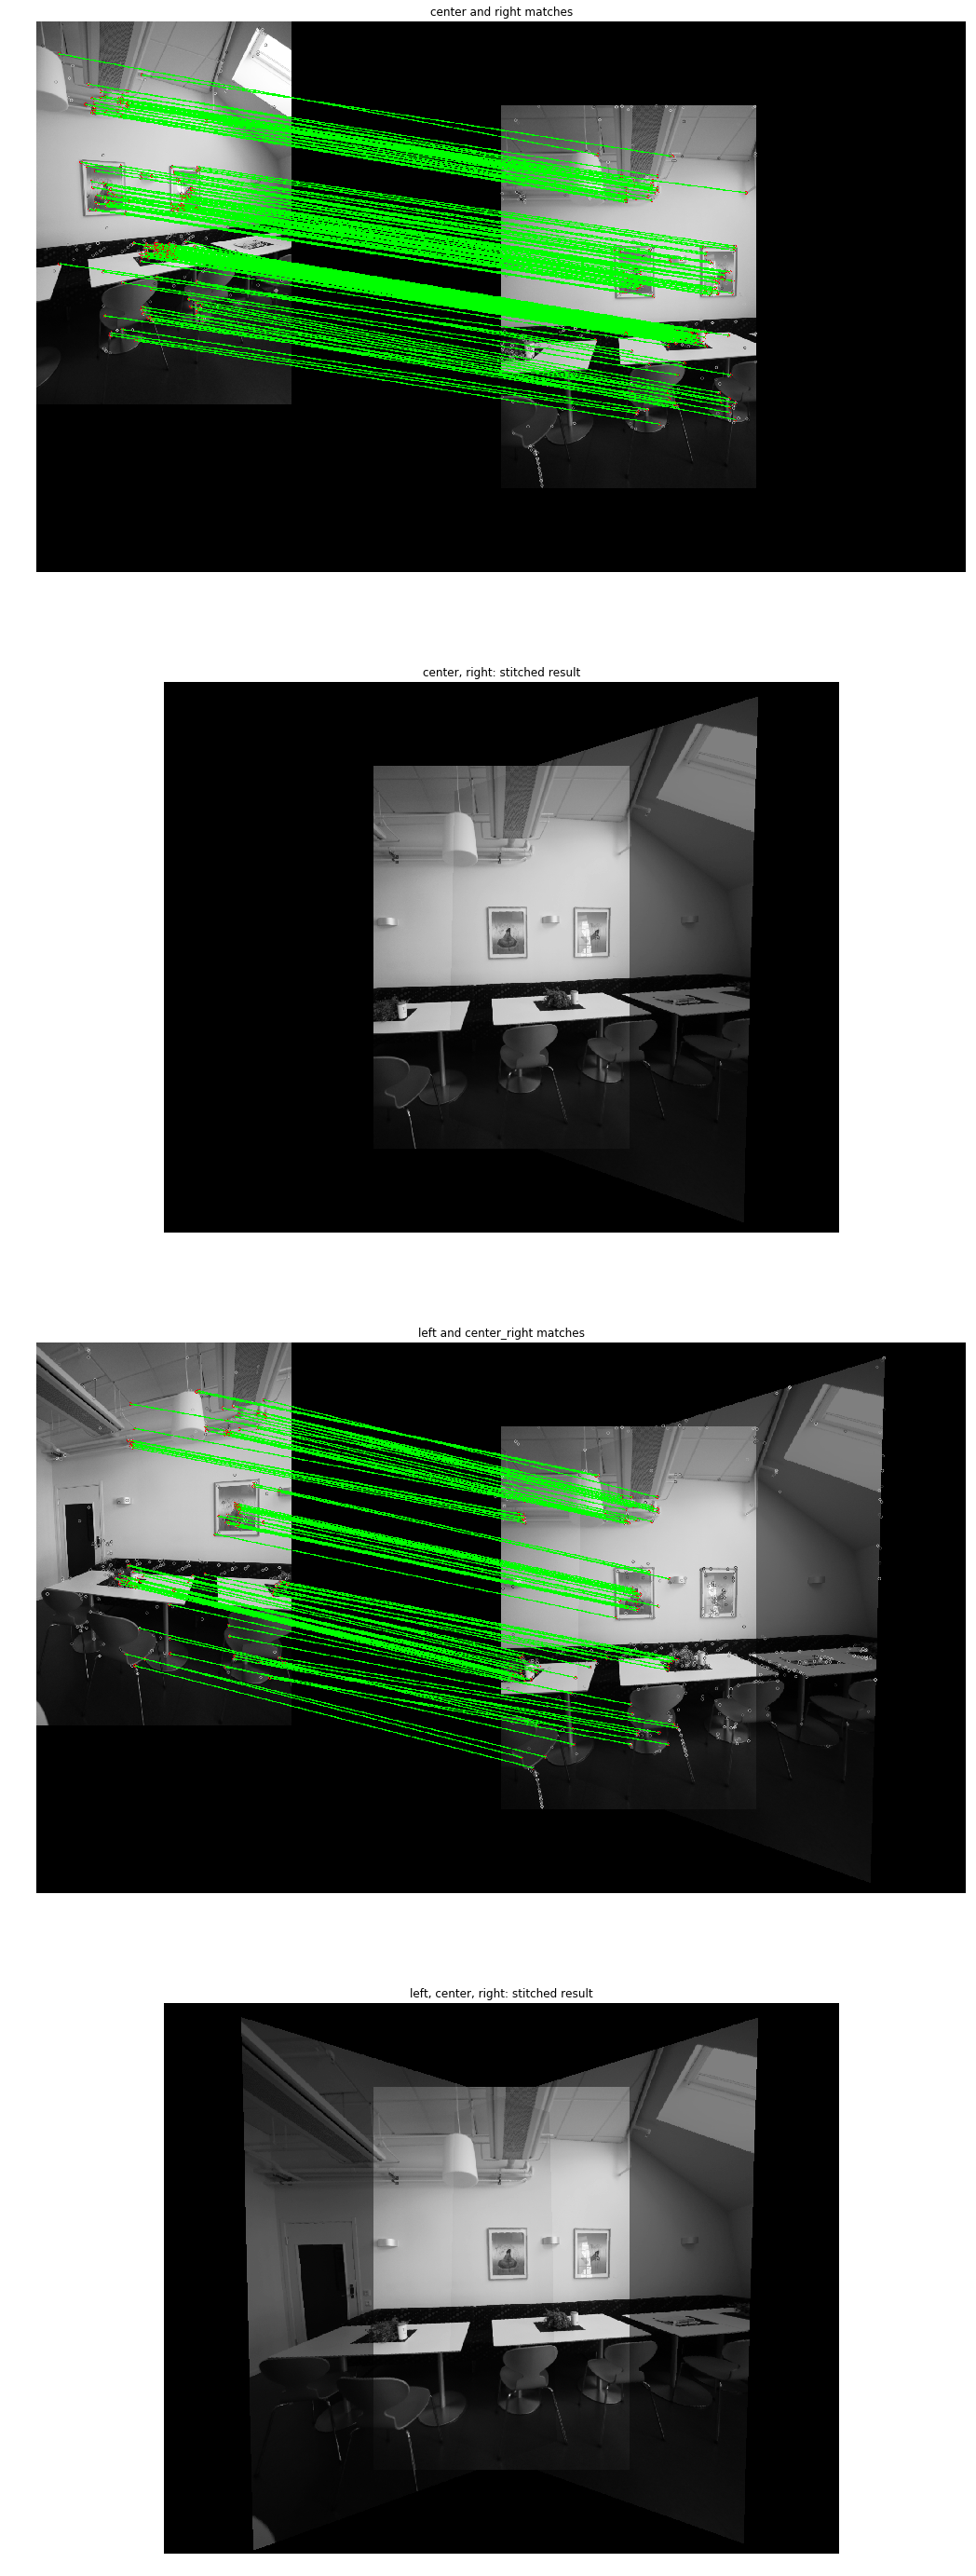

(-0.5, 1607.5, 1311.5, -0.5)

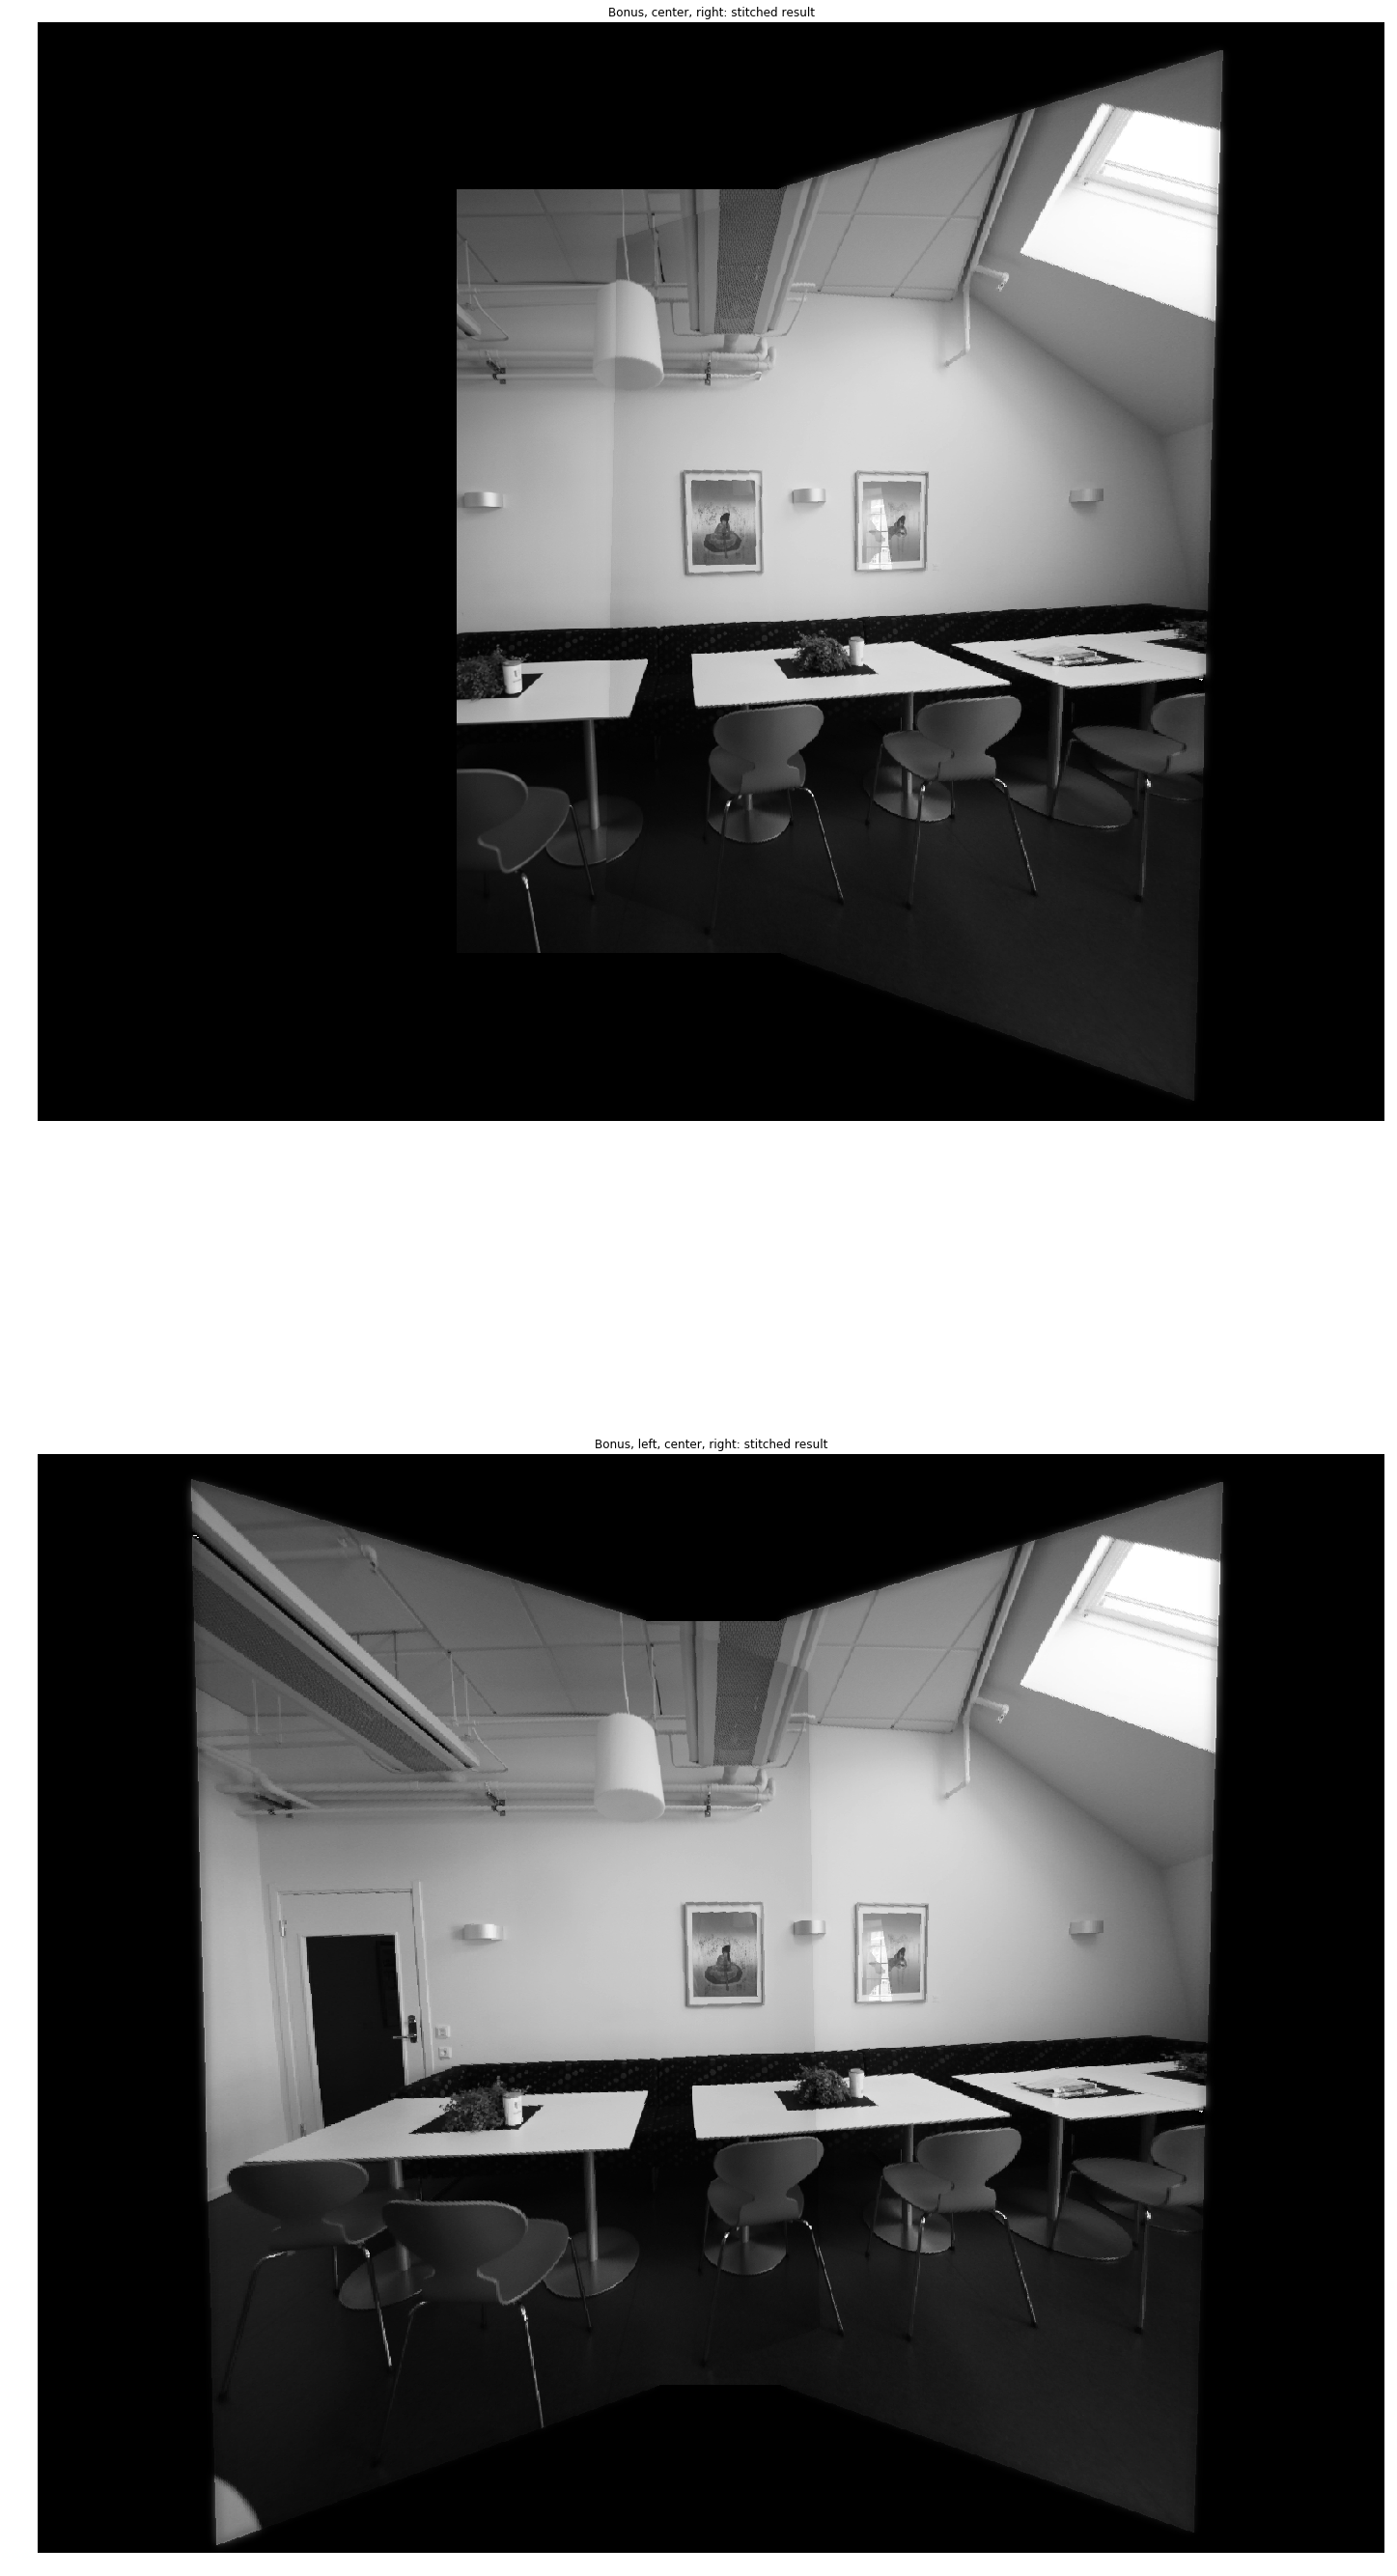

In [5]:
imgCenter = cv2.imread('SourceImages/stitch_m.png', 0)
imgRight  = cv2.imread('SourceImages/stitch_r.png', 0)
imgLeft   = cv2.imread('SourceImages/stitch_l.png', 0)

# pad the center image to a larger size 1680 X 1312
imgCenter = cv2.copyMakeBorder(imgCenter,200,200,500,500,cv2.BORDER_CONSTANT)

def extractFeatureMatches(img1, img2):
    ratio = 0.5 ## instead of 0.75 using a ratio which seems to perform better
    
    sift = cv2.xfeatures2d.SIFT_create()

    # get SIFT keypoints and descriptors
    keypoint1, descriptor1 = sift.detectAndCompute(img1, None)
    keypoint2, descriptor2 = sift.detectAndCompute(img2, None)
    
    bf = cv2.BFMatcher()
    good_matches= list()
    commonKeypointsDict = dict()

    ## get matches from img1 to img2 using KNN
    knnMatches12 = bf.knnMatch(descriptor1, descriptor2, k=2)

    ## get matches from img2 to img1 using KNN
    knnMatches21 = bf.knnMatch(descriptor2, descriptor1, k=2)
    
    
    match_dict = {}
    for i, (m, n) in enumerate(knnMatches21):
        if m.distance < ratio * n.distance:
            match_dict[m.trainIdx] = m.queryIdx

    good_matches = []

    for i, (m, n) in enumerate(knnMatches12):
        # ratio check and reverse match check
        if m.distance < ratio * n.distance and m.queryIdx in match_dict and match_dict[m.queryIdx] == m.trainIdx:
            good_matches.append(m)
                
    # draw keypoints for each of the images
    res1 = cv2.drawKeypoints(img1, keypoint1, img1)
    res2 = cv2.drawKeypoints(img2, keypoint2, img2)

    # draw the corresponding matches after converting images to grayscale
    img_match  =  drawMatches(cv2.cvtColor(res1, cv2.COLOR_BGR2GRAY),keypoint1,cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY),keypoint2,good_matches) 

    # output keypoints after applying ration and reverse matches
    points1 = list()
    points2 = list()

    for aMatch in good_matches:
        points1.append(keypoint1[aMatch.queryIdx].pt)
        points2.append(keypoint2[aMatch.trainIdx].pt)


    return (points1, points2, img_match) 

# blend two images with alpha blending
def alpha_blend(img, warped):
    
    # Convert uint8 to float
    image = img.astype(float)
    warpedImg = warped.astype(float)

    alpha = 0.5 # as per instructions
    
    #shape of new blended image is same as the image/warped image
    blendedImg = np.zeros(image.shape)

    # Add the 
    blendedImg = cv2.addWeighted( image, alpha, warpedImg, (1 - alpha), gamma=0.0) #, dst=blendedImg)
 
    return blendedImg

def pyrUpImg(gaussianPyramid_i, gaussianPyramid_i_1):
    upImg = cv2.pyrUp(gaussianPyramid_i)
    L = np.subtract(gaussianPyramid_i_1, upImg )
    return L

def Laplacian_Blending(A, B, mask, num_levels=6): 

    # assume mask is float32 [0,1]

    # initialize gaussian Pyramids
    imgA = A.copy()
    gaussianPyramidA = [imgA]
    
    imgB = B.copy()
    gaussianPyramidB = [imgB]
    
    imgMask = mask.copy()
    gaussianPyramidMask = [imgMask]

    # setup gaussian Pyramids for A, B and mask
    for i in range(num_levels):

        imgA = cv2.pyrDown(imgA)
        gaussianPyramidA.append(np.float32(imgA))
        
        imgB = cv2.pyrDown(imgB)
        gaussianPyramidB.append(np.float32(imgB))
        
        imgMask = cv2.pyrDown(imgMask)
        gaussianPyramidMask.append(np.float32(imgMask))
        
    # setup Laplacian Pyramids for A, B and mask
    laplacianA = [gaussianPyramidA[num_levels - 1]]  
    laplacianB = [gaussianPyramidB[num_levels - 1]]
    laplacianMask = [gaussianPyramidMask[num_levels - 1]]

    # complete setup
    for i in range(num_levels - 1, 0, -1): # from top to bottom
        
        laplacianA.append(pyrUpImg(gaussianPyramidA[i],gaussianPyramidA[i-1]))
        laplacianB.append(pyrUpImg(gaussianPyramidB[i],gaussianPyramidB[i-1]))
        
        laplacianMask.append(gaussianPyramidMask[i - 1]) 

    # use mask to blend images at every level 
    LS = []
    for la, lb, imgMask in zip(laplacianA, laplacianB, laplacianMask):
        ls = la * imgMask + (1.0 - imgMask) * lb
        LS.append(ls)

    # now reconstructing
    blended = LS[0]
    for i in range(1, num_levels):
        size = (LS[i].shape[1], LS[i].shape[0])
        blended = cv2.pyrUp(blended, dstsize = size)
        blended = cv2.add(blended, LS[i])

    return blended

def getTransform(src, dest):
    
    # get the common point configs from both images and image matches
    pts1, pts2, image_mtchs = extractFeatureMatches(src, dest)

    # reshape as required
    src_pts = np.float32(pts1)
    src_pts = src_pts.reshape(-1, 1, 2)

    dst_pts = np.float32(pts2)
    dst_pts = dst_pts.reshape(-1, 1, 2)

    # get transformation matrix
    transformMat, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold = 5.0)

    return (transformMat, image_mtchs)
    

def perspective_warping(imgCenter, imgLeft, imgRight):
    
    #pad the center image to a larger size 1680 X 1312
    #imgCenter = cv2.copyMakeBorder(imgCenter, 200, 200, 500, 500, cv2.BORDER_CONSTANT)
    
    # Get homography from right to center
    # ===== img_match1 is your first output =====
    (T_R2C,img_match1) = getTransform(imgRight, imgCenter)
    
    # Blend center and right
    # ===== stitched_cr is your second output =====
    # get the stiched center and right image
    ##  cv2.INTER_NEAREST - a nearest-neighbor interpolation
    stitched_cr_warped = cv2.warpPerspective(imgRight,T_R2C, (imgCenter.shape[1], imgCenter.shape[0])
                                             ,dst=imgCenter.copy(),flags=cv2.INTER_NEAREST,borderMode=cv2.BORDER_TRANSPARENT)
    stitched_cr = np.uint8(alpha_blend(stitched_cr_warped, imgCenter )) # call alpha_blend

    # Get homography from left to stitched center_right
    # ===== img_match2 is your third output =====
    (T_L2CR, img_match2) = getTransform(imgLeft, stitched_cr)
    
    # Blend left and center_right
    # get the stiched result image with center-right and left image
    ##  cv2.INTER_NEAREST - a nearest-neighbor interpolation
    # ===== stitched_res is your fourth output =====
    stitched_res_warped = cv2.warpPerspective(imgLeft,T_L2CR, (stitched_cr.shape[1], stitched_cr.shape[0])
                                              ,dst=stitched_cr.copy(), flags=cv2.INTER_NEAREST,borderMode=cv2.BORDER_TRANSPARENT)
    stitched_res = np.uint8(alpha_blend(stitched_res_warped, stitched_cr )) # call alpha_blend
    
    return stitched_res, stitched_cr, img_match1, img_match2

def perspective_warping_laplacian_blending(imgCenter, imgLeft, imgRight):
    
    # for example: transform im1 to im2's plane
    # first, make some room around im2
    #imgCenter = cv2.copyMakeBorder(imgCenter, 200, 200, 500, 500, cv2.BORDER_CONSTANT)

    # Get homography from right to center
    T_R2C, img_match1 = getTransform(imgRight, imgCenter)
    
    # get the stiched center and right image
    ##  cv2.INTER_NEAREST - a nearest-neighbor interpolation
    stitched_cr_warped_lp = cv2.warpPerspective(imgRight, T_R2C, (imgCenter.shape[1], imgCenter.shape[0]),
        dst=imgCenter.copy(), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_TRANSPARENT)
    
    stitched_cr_mask_lp = cv2.warpPerspective(np.ones_like(imgRight),T_R2C, (imgCenter.shape[1], imgCenter.shape[0]),
        dst=np.zeros_like(imgCenter), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_TRANSPARENT)
    
    # Blend center and right
    # ===== This is your first bonus output =====
    stitched_cr = np.uint8(Laplacian_Blending(stitched_cr_warped_lp, imgCenter, np.float32(stitched_cr_mask_lp), 
                                              num_levels=4))

    # Get homography from left to stitched center_right
    (T_L2CR, img_match2) = getTransform(imgLeft, stitched_cr)
    
    # get the stiched center and right image
    ##  cv2.INTER_NEAREST - a nearest-neighbor interpolation
    stitched_res_warped_lp = cv2.warpPerspective(imgLeft, T_L2CR, (stitched_cr.shape[1], stitched_cr.shape[0])
                                                 ,dst=stitched_cr.copy(), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_TRANSPARENT)
    
    stitched_res_mask_lp = cv2.warpPerspective( np.ones_like(imgLeft), T_L2CR, (stitched_cr.shape[1], stitched_cr.shape[0])
                                               ,dst=np.zeros_like(stitched_cr), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_TRANSPARENT)
    
    # Blend left and center_right
    # ===== This is your second bonus output =====
    stitched_res = np.uint8(Laplacian_Blending(stitched_res_warped_lp, stitched_cr, np.float32(stitched_res_mask_lp), 
                                               num_levels=4))

    return stitched_res, stitched_cr


# ====== Plot functions, DO NOT CHANGE =====
stitched_res, stitched_cr, img_match1, img_match2 = perspective_warping(imgCenter, imgLeft, imgRight)
stitched_res_lap, stitched_cr_lap = perspective_warping_laplacian_blending(imgCenter, imgLeft, imgRight)
        
plt.figure(figsize=(25,50))
plt.subplot(4, 1, 1)
plt.imshow(img_match1)
plt.title("center and right matches")
plt.axis('off')
plt.subplot(4, 1, 2)
plt.imshow(stitched_cr, 'gray') ## added 'gray' as per piazza post @55 response by TA
plt.title("center, right: stitched result")
plt.axis('off')
plt.subplot(4, 1, 3)
plt.imshow(img_match2)
plt.title("left and center_right matches")
plt.axis('off')
plt.subplot(4, 1, 4)
plt.imshow(stitched_res, 'gray') ## added 'gray' as per piazza post @55 response by TA
plt.title("left, center, right: stitched result")
plt.axis('off')
plt.show()

plt.figure(figsize=(25,50))
plt.subplot(2, 1, 1)
plt.imshow(stitched_cr_lap, 'gray') ## added 'gray' as per piazza post @55 response by TA
plt.title("Bonus, center, right: stitched result")
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(stitched_res_lap, 'gray') ## added 'gray' as per piazza post @55 response by TA
plt.title("Bonus, left, center, right: stitched result")
plt.axis('off')
# =============================================


## Problem 3: Object Recognition with HOG features
{30 points} You will use the histogram of oriented gradients (HOG) to extract features from objects and recognize them.

HOG decomposes an image into multiple cells, computes the direction of the gradients for all pixels in each cell, and creates a histogram of gradient orientation for that cell. Object recognition with HOG is usually done by extracting HOG features from a training set of images, learning a support vector machine (SVM) from those features, and then testing a new image with the SVM to determine the existence of an object.

You can use `cv2.HOGDescriptor` to extract the HoG feature and `cv2.ml.SVM_create` for SVMs (and a lot of other algorithms). You can also use Python machine learning packages for SVM, e.g.`scikit-learn` and for HoG computation, e.g. `scikit-image`. Please find the OpenCV SVM tutorial at https://www.learnopencv.com/handwritten-digits-classification-an-opencv-c-python-tutorial/.

An image set located under SourceImages/human_vs_cars is provided containing 20 images. You will first train an SVM with the HoG features and then predict the class of an image with the trained SVM. For simplicity, we will be dealing with a binary classification problem with two classes, namely, cars and humans. There are 10 images for each class.

Some of the function names and arguments are provided, you may change them as you see fit.

- **Step 1 (5pts)**. Load in the images and create a vector of corresponding labels (0 for car and 1 for human). An example label vector should be something like [1,1,1,1,1,0,0,0,0,0]. Shuffle the images randomly and display them in a 2 x 10 grid with figsize = (18, 15).

- **Step 2 (10pts)**. Extract HoG features from all images. You can use the OpenCV function `cv2.HOGDescriptor` or hog routine from `scikit-image`. Display the HoG features for all images in a 2 x 10 grid with figsize = (18, 15).

- **Step 3**. Use the first 16 examples from the shuffled dataset as training data on which to train an SVM. The rest 4 are used as test data. Reshape the HoG feature matrix as necessary to feed into the SVM. Train the classifier. **DO NOT train with test data.** No output is expected from this part.

- **Step 4 (15pts)**. Perform predictions with your trained SVM on the test data. Output a vector of predictions, a vector of ground truth labels, and prediction accuracy.

2 X 10 Grid of Images .... 
('Labels  >> ', [0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1])


<Figure size 1296x1080 with 0 Axes>

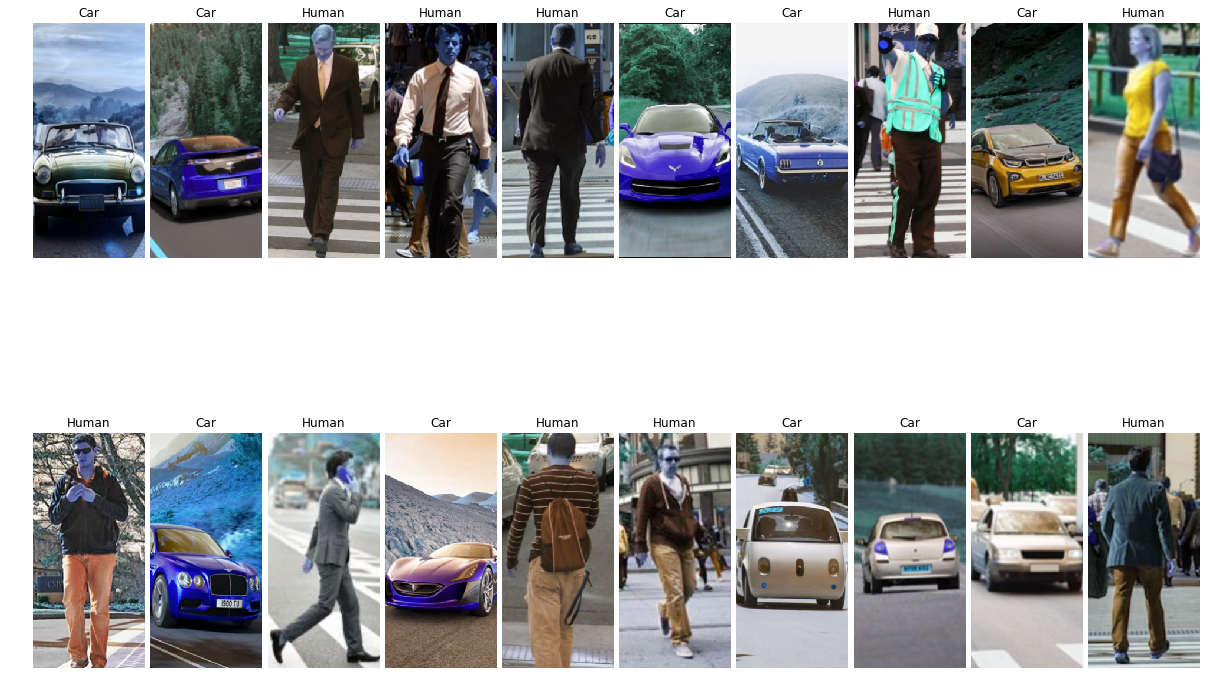

In [6]:
import skimage.exposure
from skimage.feature import hog
from sklearn.svm import LinearSVC
from skimage import exposure
from sklearn.metrics import classification_report,accuracy_score

data = list()
hogD = list()

## common grid display method (takes a list of tuples (image, <>))
## cares only about the image 
def showImageGrid(gridData):
    print("2 X 10 Grid of Images .... ")
    plt.figure(figsize=(18,15))
    
    # subplots of 2 X 10 grid
    fig, axarr = plt.subplots(nrows=2, ncols=10, figsize=(18, 15),)
    fig.subplots_adjust(left=0.05, right=0.95, hspace=0.01, wspace=0.05)
    img_idx = 0
    
    # arrange the images in 2 X 10 grid 
    for rows in range(2):
        for cols in range(10):
            axarr[rows,cols].imshow(gridData[img_idx][0])
            axarr[rows,cols].axis('off')
            if gridData[img_idx][1] == 1:
                axarr[rows,cols].set_title('Human')
            else:
                axarr[rows,cols].set_title('Car')
            img_idx += 1
    
    
# randomly shuffle the data
def shuffleData(data):
    data = np.random.shuffle(data)
    return data
    
# load data
def loadData(file):

    filepaths = list()
    
    for filenum in range(1,11):
        filepaths.append(file + str(filenum) + ".png")

    # each data index is a tuple of the (image , car/human[0/1])
    for n in range(0, len(filepaths)):
        if 'car_' in filepaths[n]: # assume labels: car = 0, human = 1
            data.append((cv2.imread( filepaths[n] ), 0),)
        else:
            data.append((cv2.imread( filepaths[n] ), 1),)
    


loadData('SourceImages/human_vs_cars/car_')
loadData('SourceImages/human_vs_cars/human_')


shuffleData(data)
# ===== Display your first graph here =====
#print(data)
showImageGrid(data)

# create a vector of labels
shuffledLabels = [data[l][1] for l in range(len(data)) ]
print("Labels  >> ", shuffledLabels)


2 X 10 Grid of Images .... 
('Labels  >> ', [0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1])


<Figure size 1296x1080 with 0 Axes>

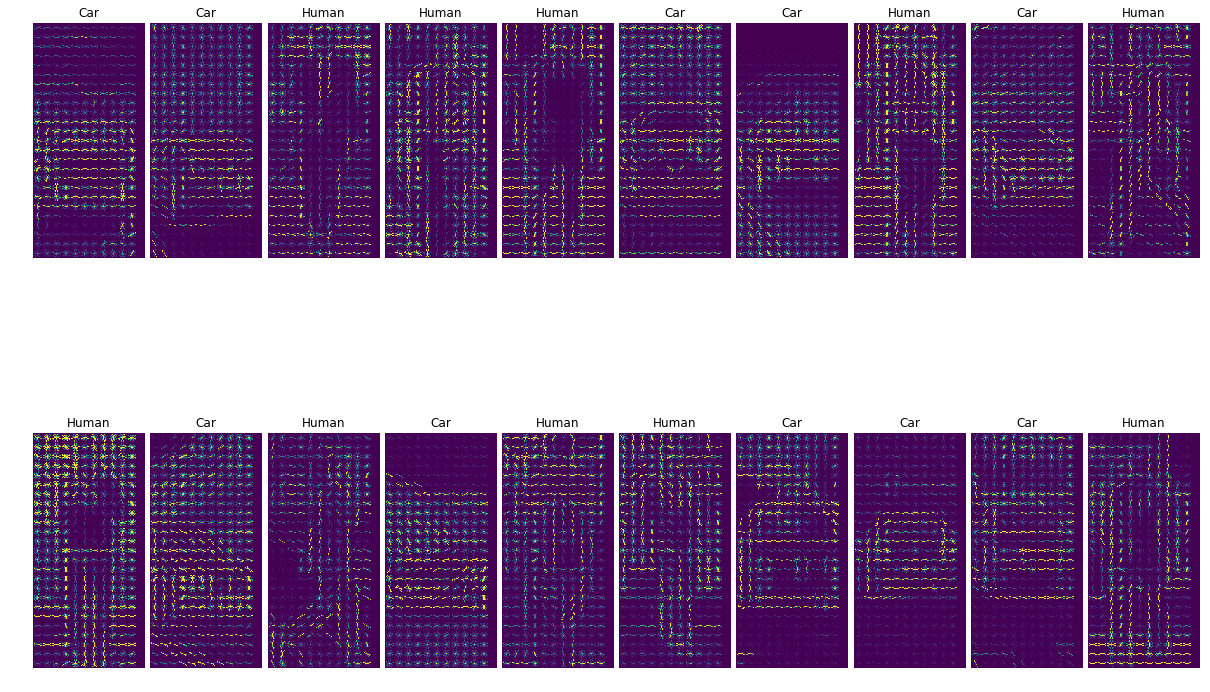

In [7]:
# Compute HOG features for the images
svmdata = list() # list of tuples of (HOG feature descriptors, labels[0/1])

def computeHOGfeatures(data):
    # Implement your computeHOGfeatures() here
    for i in range(len(data)):

        # default hog params 
        featureDesc, hog_image = hog(data[i][0], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1,1), block_norm= 'L2', visualize=True, multichannel=True)
        
        # rescalaing intensity to improve display quality
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        hogD.append((hog_image_rescaled, data[i][1]),) ## used for gridview 
        svmdata.append((featureDesc,data[i][1]),) ## used for svm model training and testing  ## feature matrix was setup - no need to reshape

# Compute HOG descriptors
computeHOGfeatures(data)

# ===== Display your second graph here =====
showImageGrid(hogD) # hog images in 2 X 10 grid 

# reshape feature matrix
## N.A. (the feature matrix was appropriately and manually stacked above in 'computeHOGfeatures()' )

# Split the data and labels into train and test set
train_ratio = float(16.0/20.0) ## take first 16 images as train as per Q
train_last_index = int(len(svmdata) * train_ratio)
#print(train_ratio)
print("Labels  >> ", shuffledLabels)

x_train = [svmdata[p][0] for p in range(0,train_last_index)]
x_test = [svmdata[p][0] for p in range(train_last_index,len(svmdata))]
y_train = [svmdata[p][1] for p in range(0,train_last_index)]
y_test = [svmdata[p][1] for p in range(train_last_index,len(svmdata))]


In [8]:
# train model with SVM

# call LinearSVC
clf = LinearSVC()

# train SVM
clf.fit(x_train,y_train)

# call clf.predict
y_pred = clf.predict(x_test)

# ===== Output functions ======
print('estimated labels: ', y_pred)# fill in here #)
print('ground truth labels: ',y_test) # fill in here #)
print('Accuracy: ', accuracy_score(y_test, y_pred) * 100, '%') # fill in here #)

('estimated labels: ', array([0, 0, 0, 1]))
('ground truth labels: ', [0, 0, 0, 1])
('Accuracy: ', 100.0, '%')


## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them. The image read and write functions are already written for you. All you need to do is to write the codes to generate proper outputs and display them.

When submitting your .zip file through blackboard, please <br> 
-- name your .zip file as Surname_Givenname_SBUID (example: Trump_Donald_11113456). <br>
-- DO NOT change the folder structre, please just fill in the blanks. <br>

You are encouraged to make posts and answer questions on Piazza. Due to the amount of emails I receive from past years, it is unfortunate that I won't be able to reply all your emails. Please ask questions on Piazza and send emails only when it is private.

To encourage you to answer questions on piazza, the three persons answering the most questions will be awarded extra 5 points at the end of the semester.

If you alter the folder strucutres, the grading of your homework will be significantly delayed and possibly penalized. And I **WILL NOT** reply to any email regarding this matter.

Be aware that your codes will undergo plagiarism checker both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.